In [1]:
''' Creation: 2021.09.12
    Last update: 2021.10.09
    
    User specific paths definition
    
    '''

# Standard library imports
from collections import Counter
import os
from pathlib import Path

# 3rd party import
import pandas as pd

#Internal import 
import PVcharacterization_Utils as pv

choose_files = False

root = Path.home()

if choose_files :
    datafiles_list = pv.select_files()
else:
    data_dir = pv.select_data_dir(root)
    datafiles_list = list(Path(data_dir).rglob("*.csv"))

list_files_descp = [pv.parse_filename(str(file)) for file in datafiles_list]
file_check = True
list_multi_file = []
for file,frequency in Counter([os.path.basename(x) for x in datafiles_list]).items(): # Check the the uniqueness of a file name
    if frequency>1:
        list_multi_file.append(file)
        file_check = False
if not file_check:
    raise Exception(f"The file(s) {' ,'.join(list_multi_file)} has(have) a number of occurrence greater than 1.\nPlease correct before proceeding")

    
df_files_descp  = pd.DataFrame(list_files_descp)
list_modules = df_files_descp['name'].unique()

database_path = Path(os.path.dirname(datafiles_list[0])) / Path(pv.DATA_BASE_NAME)

pv.df2sqlite(df_files_descp, file=database_path, tbl_name=pv.DATA_BASE_TABLE)

print(f'{len(datafiles_list)} files was detected.\ndf_files_descp and the data base table {pv.DATA_BASE_TABLE} are built')

110 files was detected.
df_files_descp and the data base table PV_descp are built


In [2]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    
    '''
# Standard library imports
import os

#Internal import 
import PVcharacterization_Utils as pv

name_select = pv.Select_items(list_modules,'Select the modules',mode = 'multiple')
pow_select = [200,400,600,800,1000,2000,4000]
trt_select = ["T0", "T1", "T2", "T3", "T4"]

querries = pv.sieve_files(pow_select,trt_select,name_select,database_path)
list_files_name = [os.path.splitext(os.path.basename(x))[0] for x in querries]
list_files_name.sort()

df_files_descp_copy = df_files_descp

df_files_descp_copy.index = [os.path.basename(x).split('.')[0] for x in df_files_descp_copy['file'].tolist()]
df_files_descp_copy = df_files_descp_copy.loc[:,['power','treatment','name'] ]

res = [pv.data_parsing(querry,parse_all=False).meta_data for querry in querries]
df_meta = pd.DataFrame.from_dict(res)
df_meta.index = df_meta['ID']
list_df_meta_index = list(df_meta.index)
list_df_meta_index .sort()

flag_name = True
list_error_name = []
for  name in zip(list_files_name ,list_df_meta_index):
    if name[0] != name[1]:
        list_error_name.append(name[0])
        flag_name = False
    if not flag_name:
        raise Exception(f"An issue with IDs has been detected with file(s) {' ,'.join(list_error_name)}.\n Please correct before proceeding")

df_meta = df_meta.loc[:,pv.USED_COLS] # keep only USED_COLS defined in PVcharacterization_GUI.py

df_meta = pd.merge(df_meta,df_files_descp_copy,left_index=True, right_index=True) # add column

pv.df2sqlite(df_meta, file=database_path, tbl_name=pv.DATA_BASE_TABLE_EXP)

df_meta.head(30)

,Title,Voc,Isc,Rseries,Rshunt,Pmax,Vpm,Ipm,Fill Factor,power,treatment,name
QCELLS901219162417702718_0200W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0200W,37.8582,2.10234,0.95559,1064.79,65.0317,32.6422,1.99225,0.81707,200,T0,QCELLS901219162417702718
QCELLS901219162417702718_0200W_T1,PERC_Q-PEAK DUO-G6_6x10 M2 0200W,37.5533,2.09451,1.04366,1026.88,64.1876,32.3753,1.98261,0.81605,200,T1,QCELLS901219162417702718
QCELLS901219162417702718_0200W_T2,PERC_Q-PEAK DUO-G6_6x10 M2 0200W,36.5690,2.02509,1.02274,1244.39,60.1832,31.4284,1.91492,0.81267,200,T2,QCELLS901219162417702718
QCELLS901219162417702718_0400W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0400W,38.9622,4.16648,0.59080,812.811,132.317,33.3385,3.96890,0.81508,400,T0,QCELLS901219162417702718
QCELLS901219162417702718_0400W_T1,PERC_Q-PEAK DUO-G6_6x10 M2 0400W,38.6710,4.15449,0.65740,751.319,130.818,33.0601,3.95697,0.81426,400,T1,QCELLS901219162417702718
QCELLS901219162417702718_0400W_T2,PERC_Q-PEAK DUO-G6_6x10 M2 0400W,37.6737,4.01816,0.66483,773.145,122.705,32.1104,3.82136,0.81058,400,T2,QCELLS901219162417702718
QCELLS901219162417702718_0600W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0600W,39.6169,6.24696,0.48938,598.006,200.057,33.561,5.96101,0.80836,600,T0,QCELLS901219162417702718
QCELLS901219162417702718_0600W_T1,PERC_Q-PEAK DUO-G6_6x10 M2 0600W,39.3261,6.22742,0.46920,528.829,197.733,33.2385,5.94893,0.80740,600,T1,QCELLS901219162417702718
QCELLS901219162417702718_0600W_T2,PERC_Q-PEAK DUO-G6_6x10 M2 0600W,38.3447,6.02381,0.4947,462.268,185.489,32.3333,5.73677,0.80304,600,T2,QCELLS901219162417702718
QCELLS901219162417702718_0800W_T0,PERC_Q-PEAK DUO-G6_6x10 M2 0800W,40.0686,8.31478,0.36748,452.075,267.033,33.7855,7.90377,0.80151,800,T0,QCELLS901219162417702718


In [3]:
''' Creation: 2021.10.09
    Last update: 2021.10.09
    
    Interactive choice of the treatment differences
    
    '''

# Standard library imports
from itertools import combinations

list_setup = []
name =[]
for x in df_meta[['name','treatment','power']].groupby('name'):
    name.append(x[0] )
    list_setup.append(set(zip(x[1]['treatment'].tolist(), x[1]['power'].tolist())))
if list_setup[1] - list_setup[0]:
    raise Exception(f'Cannot compare {name[0] } and {name[1]}')


list_diff = pv.Select_items(list(combinations(pd.unique(df_meta['treatment']), 2)),
                            'Select the difference',mode = 'multiple')
list_diff = [(x[1],x[0]) for x in list_diff]

In [4]:
def set_min_max_param(df_meta,diff=False):
    
    if diff:
        min_max_param = pv.MIN_MAX_PARAM
    else:
        USED_COLS_copy = list(pv.USED_COLS)
        USED_COLS_copy.remove("Title")
        df_meta_ = df_meta.astype(dtype={col_name:float for col_name in USED_COLS_copy}, copy=True)
        df_stat = df_meta_.describe()
        min_max_param = {param:np.array(list(value.values()))
                        for param,value in df_stat.loc[['min','max'],:].to_dict().items()}
        min_max_param = {param:[x[0] - (ecart := np.diff(x)/2),x[1] + ecart]
                        for param,x in min_max_param.items()}
        
    return min_max_param

def plot_params(params,list_exp, df_meta,list_diff = []):
    
    '''Plots for different experiments and for different parameters:
       - the relative  evolution (in %) of the parameters vs power for any treatment differences if diff=True
       - the parameters vs power for any treatment if diff=False
    The parameters values vs experiments (ID), treatment, power and are store in a dataframe like:
    
      ID                          Voc         Isc   Rseries   power treatment                                                         
   JINERGY3272023326035_0200W_T0  50.5082    1.827  1.95841     200   T0  
   JINERGY3272023326035_0200W_T1  50.6780  1.82484  1.87985     200   T1   
   JINERGY3272023326035_0200W_T2  50.3452  1.79790  2.09313     200   T2  
   JINERGY3272023326035_0400W_T0  51.8321  3.61464  1.05142     400   T0 
   
   Args:
       params (list of str): list of parameters to be plotted
       list_exp (list of str): list of experiments to be plotted
       df_meta (dataframe): dataframe organized as above
       list_diff (list of tuple): [(T1,T0),(T2,T0),...]
                                  if list_diff=[] the parameters evolution  vs power are plotted.
                                  else the parameters relative evolution in %, vs power, between
                                  treatment tuple[0] and tuple[1] are plotted.

    '''

    # Standard library imports
    from itertools import combinations

    # 3rd party import
    import matplotlib.pyplot as plt
    import numpy as np
    
    diff = bool(list_diff) # if true the parameters relative evolution in %, vs power, 
                           #    between every difference treatment are plotted
                           # if false the parameters evolution  vs power are plotted
    color = ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19'] # markers color
                                                                #  different color per power
    marker = ["o", "+", "s", "<", ">", "p"]                     # maker symbol
                                                                #  different symbol per experiment
        
    list_pow = sorted(pd.unique(df_meta['power'])) # List of different powers
    list_trt = pd.unique(df_meta['treatment'])         # list of different treatmments
    list_trt.sort()
    nbr_trt = len(list_trt)     # Number of different treatments
    
    if diff:
        dic_ax = {t:i for i,t in enumerate([x[0]+'-'+x[1] for x in list_diff])}
    else:
        dic_ax = {t:i for i,t in enumerate(list_trt)}
    
    # Set y dynamic of the plots
    if diff: # Plots relative variations of the parameters
        assert nbr_trt > 1, "not enough treatment measurements. Should be greeter than 1"
        combination_length = 2
        dic_ylim = set_min_max_param(df_meta,diff=True)        
    else:
        combination_length = 1
        dic_ylim = set_min_max_param(df_meta,diff=False)
    
    #  Set x dynamic of the plots (enlarge the power dynamic)
    pow_add_nbr = 2
    pow_add = pow_add_nbr * (max(list_pow) - min(list_pow))
    pow_min, pow_max = (
        min(list_pow) -  pow_add,
        max(list_pow) +  pow_add,
    )

    # Set the figure size and the subplots
    fig = plt.figure(figsize=(15,15) if len(params)>1 else (10,5))
    gs = fig.add_gridspec(
        len(params),
        int(nbr_trt * (nbr_trt - 1) / 2) if diff else nbr_trt,
        hspace=0,
        wspace=0
    )

    ax = gs.subplots(sharex="col", sharey="row")
    if len(params) ==1: # we trasform a 1D array to a 2D array
        ax = ax.reshape((1,np.shape(ax)[0]))
    if nbr_trt ==1: # we trasform a 1D array to a 2D array
        ax = ax.reshape((np.shape(ax)[0],1))
        
    # Loop over experiment, parameters, treatment/treatment differences and power
    for idx_exp, exp in enumerate(list_exp): # Loop on the experiments
        df_exp = df_meta.query("name == @exp")

        # split df_exp into a dic keyed by treatment (T0,T1,...). The values are dataframe df_exp
        # with column treatment=T0,T1,...
        list_trt = sorted(pd.unique(df_exp['treatment']))
        dic_trt = {trt : df_exp.query("treatment == @trt") for trt in list_trt}

        for idx_param, param in enumerate(params): # Loop on the parameter
            dic_trt_cp = {}
                
            if diff: # We deal with differences
                for trt in list_diff: # Loop on treatment difference
                    val = np.array(dic_trt[trt[1]][param].astype(float).tolist())
                    ref = np.array(dic_trt[trt[0]][param].astype(float).tolist())
                    delta = 100 * (val - ref) / ref
                    dic_trt_cp[trt[0] + "-" + trt[1]] = dic_trt[trt[1]].copy()
                    dic_trt_cp[trt[0] + "-" + trt[1]]["Delta_" + param] = delta
            else:
                for trt in list_trt:
                    dic_trt_cp[trt] = dic_trt[trt].copy()
                    dic_trt_cp[trt]["Delta_" + param] = np.array(dic_trt[trt][param].astype(float).tolist())

            list_trt_diff = sorted(dic_trt_cp.keys())
    
            for key in list_trt_diff:
                idx_trt = dic_ax[key]
                for idx_power,x_y in enumerate(zip(dic_trt_cp[key]["power"],
                                                   dic_trt_cp[key]["Delta_" + param])):
                    ax[idx_param, idx_trt].scatter(
                            x_y[0],
                            x_y[1],
                            c=color[idx_power] ,
                            marker=marker[idx_exp],
                            label=exp+' '+str(x_y[0]))


                if diff: ax[idx_param, idx_trt].axhline(y=0, color="red", linestyle="--")
                if idx_param == 0:
                    ax[idx_param, idx_trt].set_title(key)
                ax[idx_param, idx_trt].set_xlabel("Power ($W/{m^2}$)")
                if idx_trt == 0:
                    if combination_length > 1:
                        ax[idx_param, idx_trt].set_ylabel("$\Delta$ " + param + " (%)")
                    else:
                        ax[idx_param, idx_trt].set_ylabel(f'{param} ({pv.PARAM_UNIT_DIC[param]})')
                ax[idx_param, idx_trt].tick_params(axis="x", rotation=90)
                ax[idx_param, idx_trt].set_xticks(list_pow, minor=False)
                ax[idx_param, idx_trt].set_xticklabels(list_pow, fontsize=12)
                ax[idx_param, idx_trt].set_xlim([pow_min, pow_max])
                ax[idx_param, idx_trt].set_ylim(dic_ylim.get(param,[-3.2, 1.6]))
                for axis in ["top", "bottom", "left", "right"]:
                    ax[idx_param, idx_trt].spines[axis].set_linewidth(2)
                    
    labels_handles = {
                      label: handle for ax in fig.axes 
                      for handle, label in zip(*ax.get_legend_handles_labels())
                     }
    fig.legend(
               labels_handles.values(),
               labels_handles.keys(),
               loc='center right',
               bbox_to_anchor=(0.6,0, 0.5, 1),
               bbox_transform=plt.gcf().transFigure,
     )
    

WARNING parameter bidon will be ignored
WARNING parameter trarmiz will be ignored


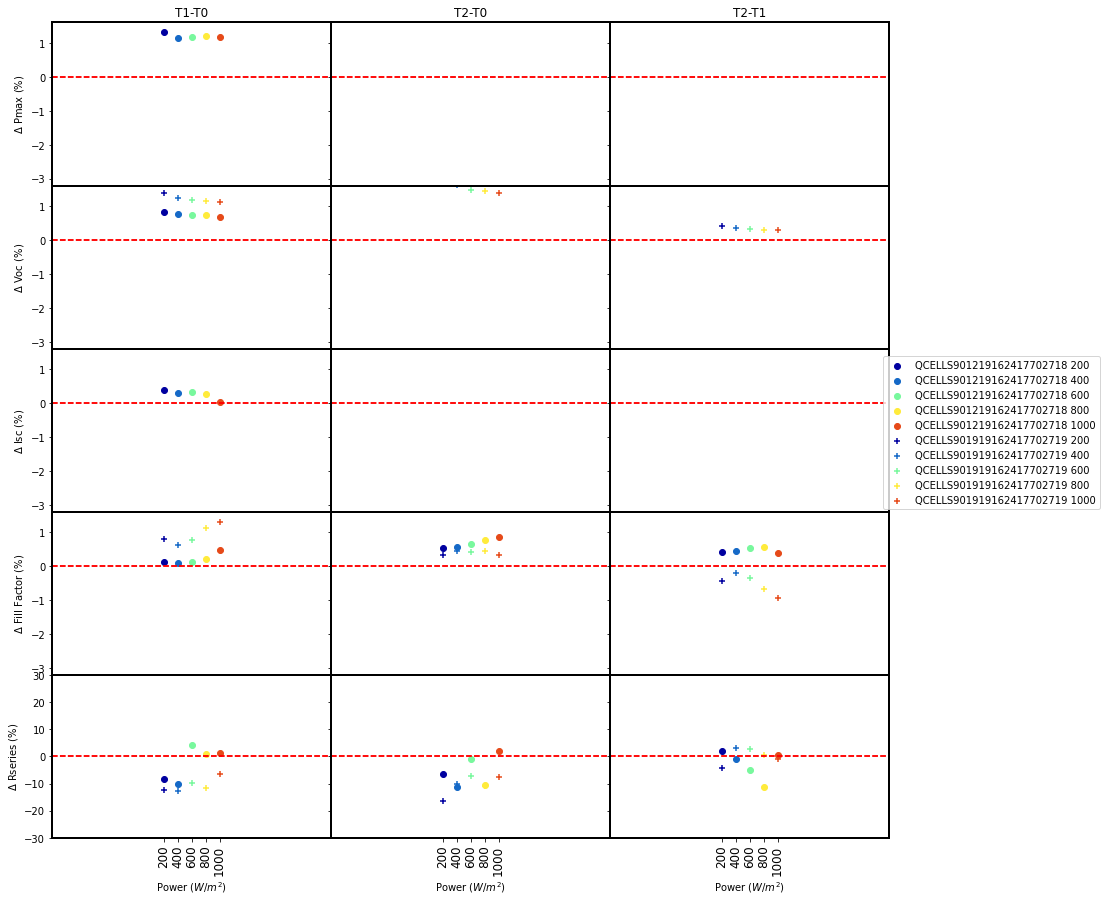

In [5]:
''' Creation: 2021.09.19
    Last update: 2021.10.09
    
    Plotting of parameters evolution.
    
    '''

#Internal import 
import PVcharacterization_Utils as pv

params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']
params_copy = list(params)
unkown_params = set(params_copy).difference(set(pv.USED_COLS))
for unknow_param in unkown_params:
    print(f'WARNING parameter {unknow_param} will be ignored')
    params.remove(unknow_param)
    
list_exp = pd.unique(df_meta['name'])          # List of experiment name (ID)
plot_params(params,list_exp,df_meta,list_diff = list_diff)


In [ ]:
''' Creation: 2021.09.19
    Last update: 2021.09.20
    
    Plotting of I/V curves.
    
    '''

# 3rd party import
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv

pow_select = [1000]
name_select = ["JINERGY3272023326035",]
trt_select = ["T0","T1","T2"]

querries = pv.sieve_files(pow_select,trt_select,name_select,database_path)

for i, res in enumerate([pv.data_parsing(querry).IV0 for querry in querries]):
    plt.plot(res['Voltage'],res['Current'],label=trt_select[i])
    plt.scatter(res['Voltage'][::50],res['Current'][::50],s=10)
    plt.xlabel(res.columns[0] +'[V]')
    plt.ylabel(res.columns[1] +'[A]')
    plt.title(f'Irradiation: {str(pow_select[0])} {pv.PARAM_UNIT_DIC["IrrCorr"]}')
    
plt.legend()
plt.show()

    

In [ ]:
import sqlite3
from string import Template

trt_select = ['T0']
name = ['DINERGY3272023326035']
conv2str = lambda list_: str(tuple(list_)).replace(",)", ")")

conn = sqlite3.connect(database_path)
cur = conn.cursor()

querry_d = Template(
    """SELECT Pmax, power
       FROM $table_name 
       WHERE
       treatment IN $trt_select
       AND name IN $name
                   """
)

cur.execute(
    querry_d.substitute(
        {
            "table_name": pv.DATA_BASE_TABLE_EXP,
            "trt_select": conv2str(trt_select),
            "name": conv2str(name)
        }
    )
)

res = cur.fetchall()
Pmax = [float(x[0]) for x in res]
power = [float(x[1]) for x in res]
cur.close()
conn.close()
Pmax, power